# Time Series Forecasting with Transformer
본 실습에서는 변압기를 통해 측정된 ETT (Electricity Transformer Temparature) 데이터셋을 활용한다. 이 데이터에는 전력 부하와 관련된 수치들이 관측되어 있다. 우리는 이 값들이 미래에 어떻게 변하는지를 예측(forecasting)하는 모델을 구현한다. 이를 통해 우리는 미래의 전력 부하를 미리 파악할 수 있고 문제 상황에 미리 대비할 수 있다. 우리는 96개의 관측값을 줬을 때, 96개의 미래 값을 예측하는 테스크를 수행한다.

## 라이브러리 불러오기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/Othercomputers/내 컴퓨터/시계열/실습1')

In [5]:
!ls

01_시계열_예측_배포.ipynb  checkpoints	dataset  __pycache__  results  test_results  utils.py


In [6]:
import argparse
import math
import random
import time
import os
import warnings
import matplotlib
from copy import deepcopy
import json
import torch
import numpy as np

from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

from math import sqrt
from matplotlib import pyplot as plt
from torch import optim
from typing import Tuple, List, Dict, Any, Type

from utils import *

warnings.filterwarnings('ignore')

%matplotlib inline

def fix_seed():
    random.seed(59683)
    torch.manual_seed(59683)
    np.random.seed(59683)
fix_seed()

## 하이퍼파라미터 세팅
하이퍼파라미터는 아래와 같이 고정한다.

In [7]:
hyper_param = argparse.Namespace(is_training=1, model_id='ETTm1_96_96', data='ETTm1',
                                 root_path='dataset/ETT-small/', data_path='ETTm1.csv',
                                 checkpoints='./checkpoints/', seq_len=96, label_len=48,
                                 pred_len=96, enc_in=7, dec_in=7, c_out=7, d_model=512,
                                 n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25,
                                 dropout=0.0, activation='gelu', num_workers=10, itr=1, train_epochs=10,
                                 batch_size=32, patience=3, learning_rate=0.0001, des='Exp', use_gpu=True, gpu=0)

하이퍼 파라미터에 접근은 아래와 같이 hyper_param.이름 으로 가능하다.

In [8]:
print(hyper_param.batch_size)  # 배치 사이즈 접근
print(hyper_param.learning_rate)  # learning rate 접근

32
0.0001


GPU 사용을 위해 device를 세팅한다.

In [9]:
device = torch.device('cuda:{}'.format(hyper_param.gpu))
print('Use GPU: cuda:{}'.format(hyper_param.gpu))

Use GPU: cuda:0


## 데이터 전처리 및 미리 보기

Timeseries forecasting 연구에서 가장 많이 사용되는 데이터셋 중 하나인 ETT (Electricity Transformer Temparature) 데이터셋은 전력 공급과 관련된 모니터링을 위해서 구축된 데이터이다. 2016년 7월 ~ 2018년 7월 기간동안 변압기를 통해 측정되었다. 총 7개의 feature를 가지며, 모두 전력 부하(power load)와 관련된 feature이다.

각 feature의 명칭과 간단한 의미는 다음과 같다.

| Field | date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| Description | The recorded **date** |**H**igh **U**se**F**ul **L**oad | **H**igh **U**se**L**ess **L**oad | **M**iddle **U**se**F**ul **L**oad | **M**iddle **U**se**L**ess **L**oad | **L**ow **U**se**F**ul **L**oad | **L**ow **U**se**L**ess **L**oad | **O**il **T**emperature |


우리가 사용하는 ETTm1 데이터셋은 ETT 데이터셋 중의 한 종류로써, 15분 간격으로 측정된 데이터셋이다. 학습 데이터, 검증 데이터, 테스트 데이터는 각각 12개월, 4개월, 4개월의 관측치로써, 34,369개, 11,425개, 11,425개의 갯수를 가진다.
7개의 feature 외에 시간 정보가 따로 기록되어 있다. 이때 시간 정보는 시간, 요일(1\~7), 일(1\~31), 연간 기준 일(1\~365)이 정규화 과정을 거쳐 [-0.5, 0.5] 사이의 값으로 기록되어 있다.

데이터로더를 정의한다. 이때, data_provider함수는 데이터와 데이터로더를 만들어주는 함수이다.

In [10]:
class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


def time_features(dates):
    return np.vstack([feat(dates) for feat in
                      [HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear()]])


class Dataset_ETT_minute(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 data_path='ETTm1.csv', scale=True):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.scale = scale

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 * 4 - self.seq_len, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - self.seq_len] # 0 : 시작점 , 1 : 1년 데이터 마지막 시퀀스, 2 : 1년 4개월 데이터 마지막 시퀀스
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4] # 0 : 1년 데이터 끝, 1 : 1년 4개월 데이터 끝, 2 : 1년 8개월 데이터 끝
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(pd.to_datetime(df_stamp['date'].values))
        data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
      # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
      # -> [0, 1], [1, 2], [2, 3], [3. 4], [4, 5], [5, 6], [6, 7] ... [8. 9]  길이 = 2, step = 1인 경우
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len # label_len = start token 길이 -> output 시작부분의 앞에 start token이 붙여서 나오니까
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1


def data_provider(args, flag):
    Data = Dataset_ETT_minute

    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len])
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

In [11]:
fix_seed()
_, train_loader = data_provider(hyper_param, 'train')
_, vali_loader = data_provider(hyper_param, 'val')
_, test_loader = data_provider(hyper_param, 'test')

train 34369
val 11425
test 11425


데이터를 자세히 파악하기 위해, 학습 데이터로더에서 하나의 미니배치를 추출한다.

In [12]:
# train_loader라는 dataloader에서 미니배치 하나를 추출하는 코드
one_sample_mini_batch = next(iter(train_loader))

print(type(one_sample_mini_batch))
print(len(one_sample_mini_batch))

<class 'list'>
4


데이터 로더가 반환한 `one_sample_mini_batch`는 길이가 4인 list이다. list의 각 index 별 의미는 다음과 같다.
- one_sample_mini_batch[0]: 이미 관측되어 주어진 데이터의 피쳐 정보
- one_sample_mini_batch[1]: 예측 해야하는 데이터의 피쳐 정보
- one_sample_mini_batch[2]: 이미 관측되어 주어진 데이터의 시간 정보
- one_sample_mini_batch[3]: 예측 해야하는 데이터의 시간 정보

In [13]:
input_series = one_sample_mini_batch[0]
output_series = one_sample_mini_batch[1]
input_time = one_sample_mini_batch[2]
output_time = one_sample_mini_batch[3]

print(input_series.shape)
print(output_series.shape)
print(input_time.shape)
print(output_time.shape)

torch.Size([32, 96, 7])
torch.Size([32, 144, 7])
torch.Size([32, 96, 4])
torch.Size([32, 144, 4])


새로 정의된 네 변수의 정보는 다음과 같다.
- input_series: 인풋 시계열 데이터 / Shape: [배치 사이즈, 시계열 데이터 길이, 피쳐 수]
- output_series: 타겟 시계열 데이터 / Shape: [배치 사이즈, 시계열 데이터 길이, 피쳐 수]
- input_time: 인풋 시간 정보 (시간, 요일, 일, 연간 기준 일) / Shape: [배치 사이즈, 시계열 데이터 길이, 시간 정보]
- output_time: 타겟 시간 정보 (시간, 요일, 일, 연간 기준 일) / Shape: [배치 사이즈, 시계열 데이터 길이, 시간 정보]

예시 데이터를 확인하기 위해 index 0의 데이터에서, index 0의 순서에 관측된 피쳐 값을 확인한다.

인풋과 타겟 시계열 데이터의 피쳐는 총 일곱개가 있어야 되며, 인풋과 타겟의 시간 정보는 네개가 있어야 한다.

In [14]:
print(input_series[0, 0, :])  # [index 0의 시계열, index 0의 순서, 모든 피쳐 정보]
print(output_series[0, 0, :])  # [index 0의 시계열, index 0의 순서, 모든 피쳐 정보]
print(input_time[0, 0, :])  # [index 0의 시계열, index 0의 순서, 모든 시간 정보]
print(output_time[0, 0, :])  # [index 0의 시계열, index 0의 순서, 모든 시간 정보]

tensor([-0.2215, -0.4306, -0.0759, -0.3743, -0.6465,  0.2906, -0.8546],
       dtype=torch.float64)
tensor([-1.6454, -0.1425, -1.7050, -0.3005, -0.3832,  0.4345, -0.2410],
       dtype=torch.float64)
tensor([-0.4565,  0.0000, -0.4000, -0.1630], dtype=torch.float64)
tensor([ 0.0652,  0.0000, -0.4000, -0.1630], dtype=torch.float64)


우리는 96개의 인풋 시계열 데이터가 주어졌을 때, 길이가 96인 타겟 시계열 데이터 값을 예측하는 것이 우리의 목표라고 하였다.
하지만 현재 타겟 시계열 데이터의 관측 시간 길이는 96이 아닌 144이다.


이것의 이유는 타겟 시계열 데이터의 앞 48개의 관측치가 forecasting 모델에서 start token의 역할을 할 것이기 때문이다.
즉, 아래 그림과 같이 인풋 시계열 데이터의 뒷 48개의 관측치와 타겟 시계열 데이터의 앞 48개의 관측치는 서로 같은 값을 가진다.

![input](https://github.com/eogns282/temptempsk/blob/main/pbl_1_image.jpeg?raw=true)

따라서 인풋 시계열 데이터의 index -48의 관측값과 타겟 시계열 데이터의 index 0의 관측값이 같은 것을 확인할 수 있다.

In [15]:
print(input_series[0, -48, :])  # 인풋 시계열 데이터의 뒤에서 48번째 관측치
print(output_series[0, 0, :])  # 타겟 시계열 데이터의 앞에서 0번째 관측치
print(input_time[0, -48, :])  # 인풋 시계열 데이터의 뒤에서 48번째 시간 정보
print(output_time[0, 0, :])  # 타겟 시계열 데이터의 앞에서 0번째 시간 정보


print(all(input_series[0, -48, :] == output_series[0, 0, :]))
print(all(input_time[0, -48, :] == output_time[0, 0, :]))

tensor([-1.6454, -0.1425, -1.7050, -0.3005, -0.3832,  0.4345, -0.2410],
       dtype=torch.float64)
tensor([-1.6454, -0.1425, -1.7050, -0.3005, -0.3832,  0.4345, -0.2410],
       dtype=torch.float64)
tensor([ 0.0652,  0.0000, -0.4000, -0.1630], dtype=torch.float64)
tensor([ 0.0652,  0.0000, -0.4000, -0.1630], dtype=torch.float64)
True
True


현재 사용 중인 시계열 데이터에서 관측된 피쳐 수는 7이다. 주어진 인풋 시계열 데이터(위의 `input_series` 변수) 와 타겟 시계열 데이터 (위의 `output_series` 변수) 중 예측해야할 부분 사이에서, 7개의 feature 중 두 데이터셋에서의 평균값 차이가 가장 큰 feature는 몇 번째 Index의 feature인지 알아보자.

- 사용 중인 Encoder와 Decode의 인풋 데이터 세팅으로 인하여, 타겟 시계열 데이터에 start token이 포함 되어 있다. 이 start token은 인풋 시계열 데이터의 일부이며, 우리가 예측해야 할 값이 아니다. 따라서, 타겟 시계열 데이터에서 7개의 feature들에 대한 평균값을 측정할 때, start token은 평균값 계산에 포함하지 않는다.

In [16]:
feature_mean_input = input_series.mean(axis=[0, 1]).numpy()
feature_mean_output = output_series[:, 48:, :].mean(axis=[0, 1]).numpy()
diff_mean = feature_mean_input - feature_mean_output
diff_mean = np.abs(diff_mean)

In [17]:
diff_mean.argmax()

4

우리는 feature마다의 값이 어떻게 분포되었는지를 보고자 한다. 인풋 시계열 데이터인 input_series에 대하여 x축을 feature의 index로 하는 box plot을 시각화 한다.

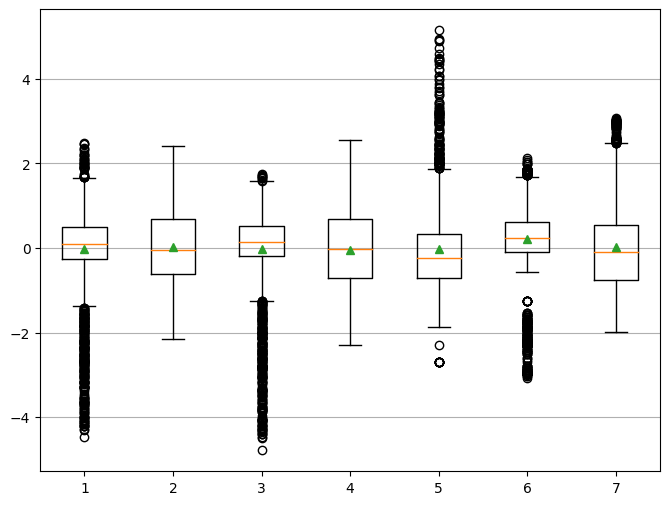

In [18]:
fig = plt.figure(figsize=(8, 6))

plt.boxplot(input_series.reshape([-1, 7]).transpose(0, 1), showmeans=True);
plt.grid(axis='y')

인풋 시계열 데이터 (input_series) 와 타겟 시계열 데이터 (output_series) 는 각 데이터 index에 따라 서로 같은 시계열에서 추출된 데이터이다. 예를 들어 input_series[0]과 output_series[0]은 서로 같은 시계열에서 만들어진 데이터이다. 즉 같은 index의 인풋 시계열 데이터와 타겟 시계열 데이터를 함께 연결하여, 하나의 시계열 데이터로 시각화 할 수 있다. 인풋 시계열 데이터와 타겟 시계열 데이터에서 index 0의 데이터를 하나의 시계열로 연결하여 시각화한다.

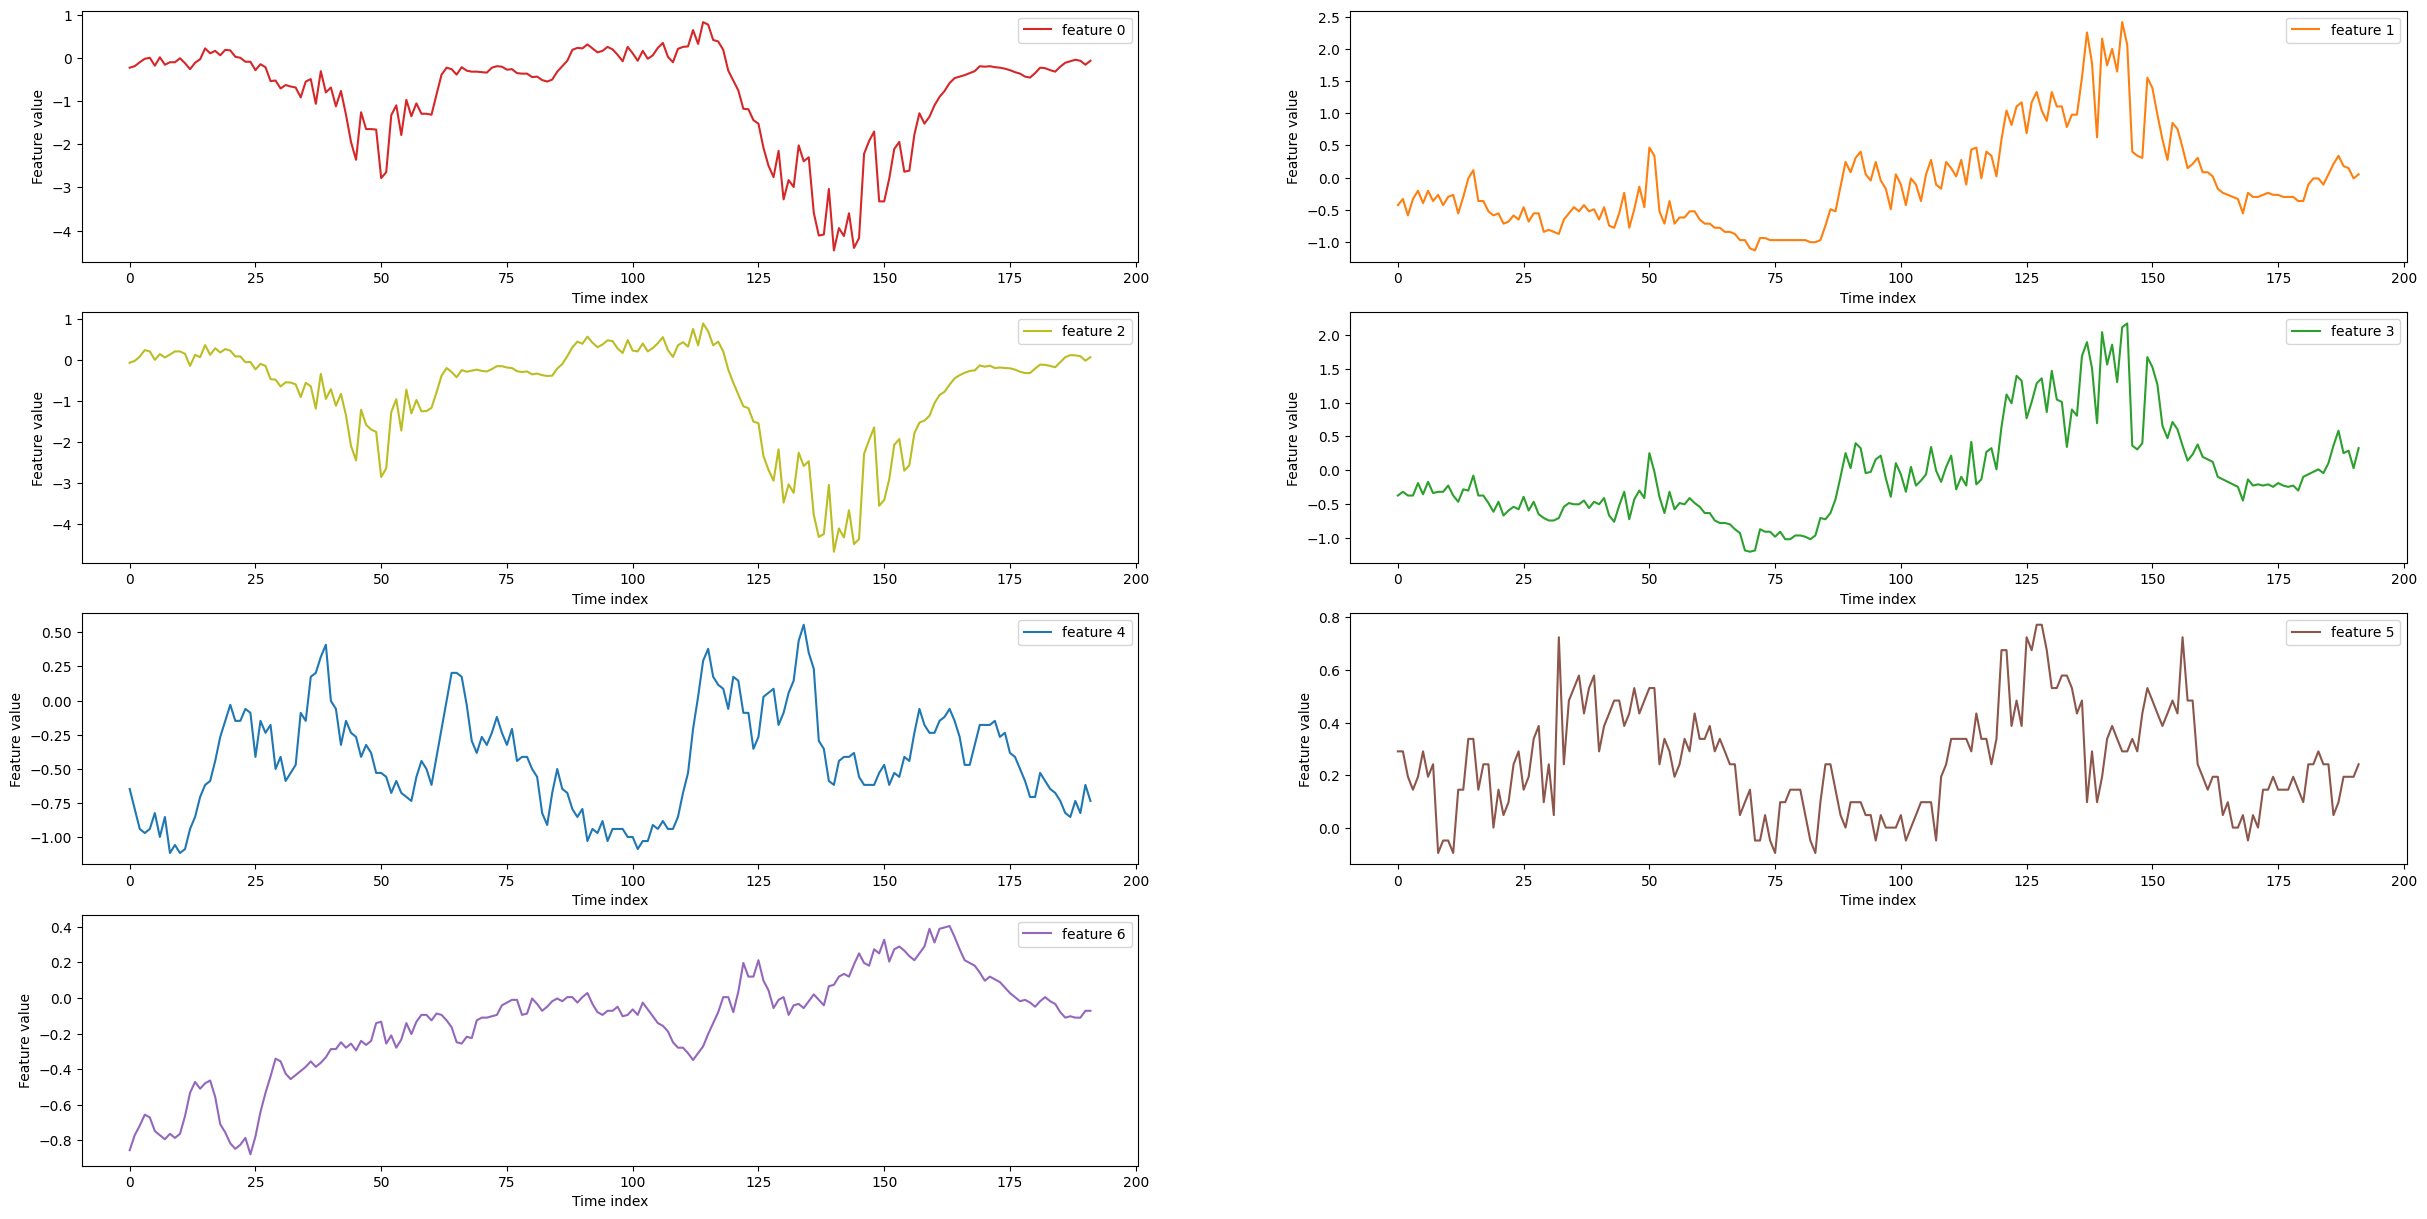

In [19]:
colors = ['#d62728', '#ff7f0e', '#bcbd22', '#2ca02c', '#1f77b4', '#8c564b', '#9467bd']
fig = plt.figure(figsize=(30, 15))

for feature_idx in range(7):  # 7개의 feature를 그리기 위한 for loop
    plt.subplot(int(f'42{feature_idx+1}'))

    ts = torch.concat([input_series[0, :, feature_idx], output_series[0, 48:, feature_idx]], 0)

    plt.plot(ts, color=colors[feature_idx], label=f'feature {feature_idx}')
    plt.xlabel('Time index')
    plt.ylabel('Feature value')
    plt.legend()

이번에는 인풋 시간정보(input_time)와 타겟 시간정보(output_time)에서 index 0의 time embedding들을 하나의 time embedding으로 연결하여 시각화한다.

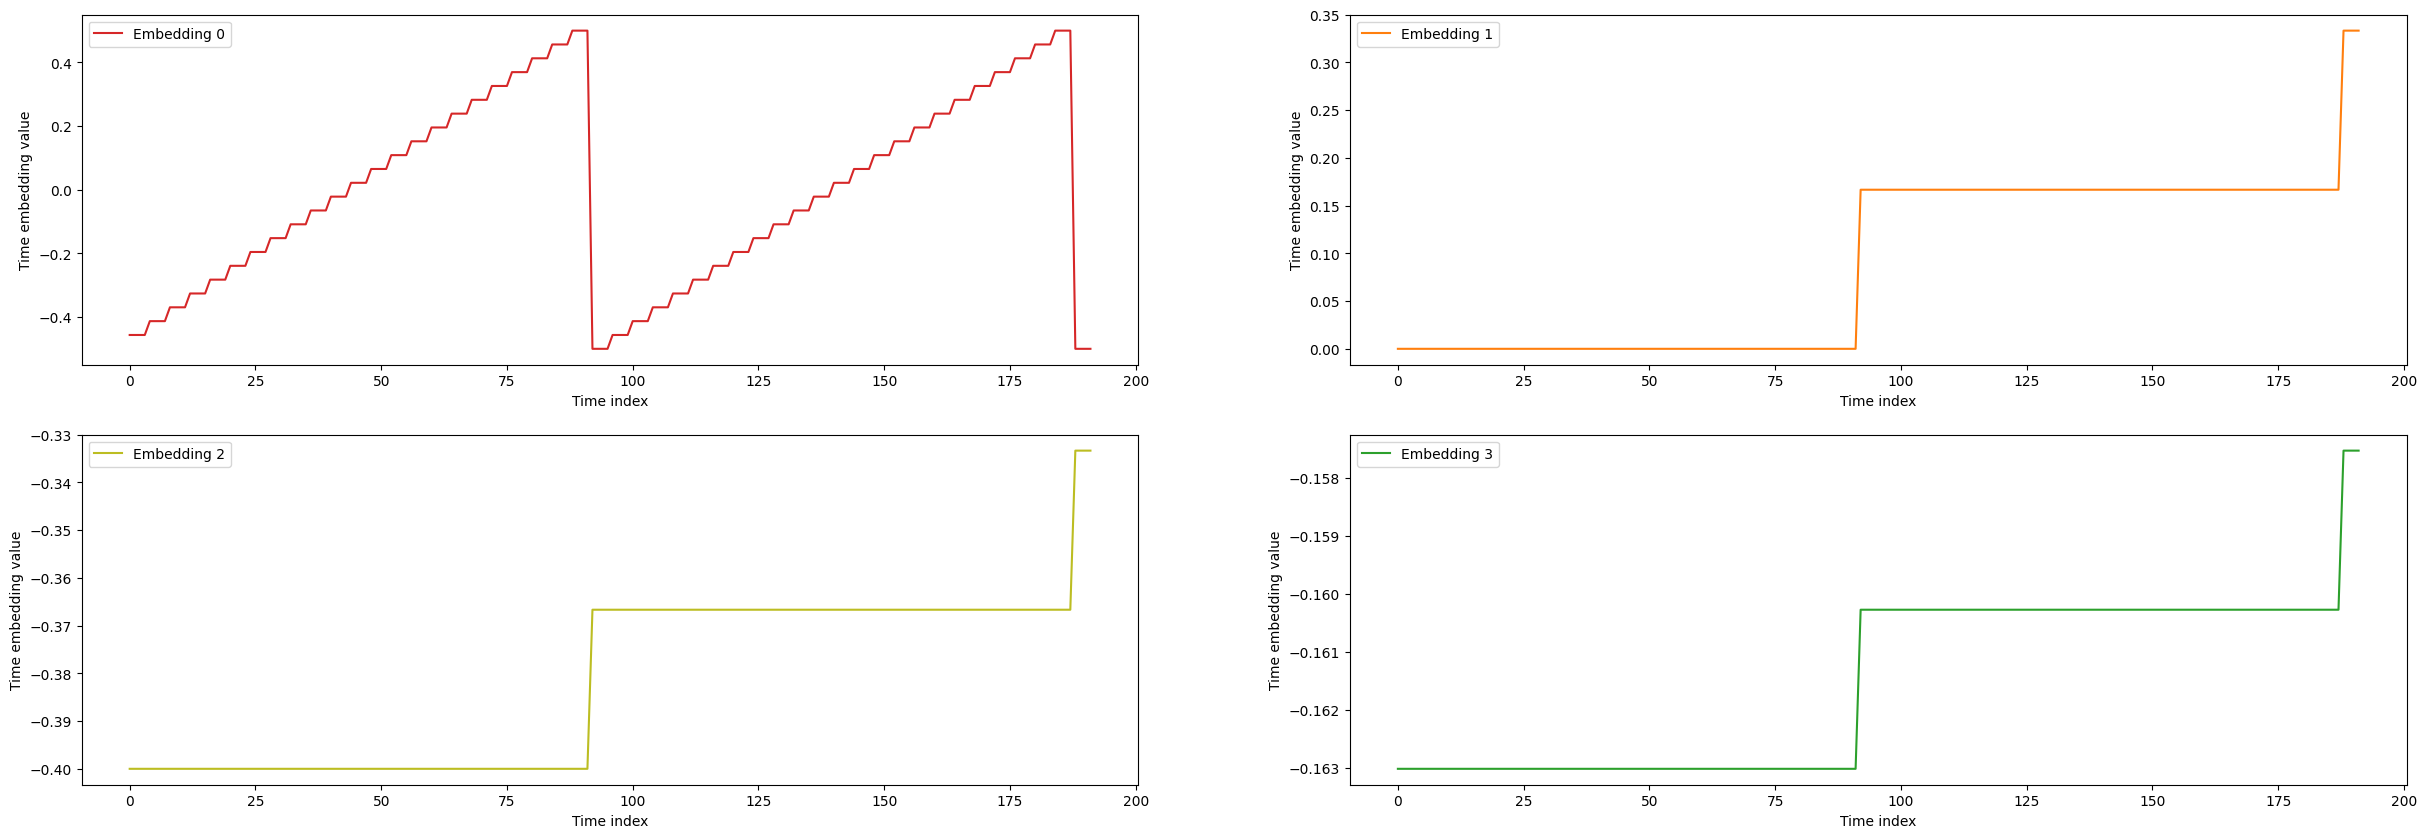

In [20]:
colors = ['#d62728', '#ff7f0e', '#bcbd22', '#2ca02c', '#1f77b4', '#8c564b', '#9467bd']
fig = plt.figure(figsize=(30, 10))

for embedding_idx in range(4):  # 4개의 embedding vector를 그리기 위한 for loop
    plt.subplot(int(f'22{embedding_idx+1}'))
    ts = torch.concat([input_time[0, :, embedding_idx], output_time[0, 48:, embedding_idx]], 0)
    plt.plot(ts, color=colors[embedding_idx], label=f'Embedding {embedding_idx}')
    plt.xlabel('Time index')
    plt.ylabel('Time embedding value')
    plt.legend()

아래 그림은 데이터를 모델의 input으로 사용하기 위해, 데이터의 embedding vector를 만드는 방식을 시각화 한 것이다. 이 그림을 참고하여 아래 DataEmbedding class를 구현한다.
- 구현되어 있는 총 세개의 class와 그림은 아래와 같이 매칭이 된다.
    - TimeFeatureEmbedding class은 그림의 Global Time Stamp에 해당
    - PositionalEmbedding class은 그림의 Local Time Stamp에 해당
    - TokenEmbedding class은 그림의 Scalar에 해당
    - 그림을 보면 DataEmbedding class는 TimeFeatureEmbedding, PositionalEmbedding, TokenEmbedding의 합으로 계산되는 것을 알 수 있다.

![image.png](https://github.com/eogns282/temptempsk/blob/main/pbl_2_image.jpeg?raw=true)

In [21]:
fix_seed()
# 데이터의 피쳐를 embedding
# 그림의 Scalar에 해당
class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model):
        super(TimeFeatureEmbedding, self).__init__()
        d_inp = 4
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        # Assume that x is global time information including hour, week and month
        return self.embed(x)

# 인풋 시리즈 내부의 순서 정보를 embedding
# 그림의 Local Time Stamp에 해당
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

# 시간 정보를 embedding
# 그림의 Global Time Stamp에 해당
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x

# 최종 data embedding 계산
class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TimeFeatureEmbedding(d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, time_feature, time_info):
        '''
        time_feature: 시계열 피쳐 정보
        time_info: 시간 정보
        '''
        ve = self.value_embedding(time_feature)
        pe = self.position_embedding(time_feature)
        te = self.temporal_embedding(time_info)

        #### 최종 데이터 임베딩 형태는?
        data_embedding = ve + pe + te

        output = self.dropout(data_embedding)

        return output

In [22]:
# Data Embedding class 선언
enc_embedding = DataEmbedding(hyper_param.enc_in, hyper_param.d_model, hyper_param.dropout)

In [23]:
# Data Embedding 계산
sample_emb = enc_embedding(input_series.float(), input_time.float())

In [24]:
# Embedding 후 데이터 shape 확인
sample_emb.shape

torch.Size([32, 96, 512])

Attention block인 FullAttention class를 구현한다. 이때 torch.einsum 함수를 사용하며 사용법은 아래와 같다.
- torch.einsum에서 인풋으로 사용될 dimension 정보를 입력해주면 됨
- torch.einsum의 사용법은 아래와 같음

```
>>> # trace
>>> torch.einsum('ii', torch.randn(4, 4))
tensor(-1.2104)

>>> # diagonal
>>> torch.einsum('ii->i', torch.randn(4, 4))
tensor([-0.1034,  0.7952, -0.2433,  0.4545])

>>> # outer product
>>> x = torch.randn(5)
>>> y = torch.randn(4)
>>> torch.einsum('i,j->ij', x, y)
tensor([[ 0.1156, -0.2897, -0.3918,  0.4963],
        [-0.3744,  0.9381,  1.2685, -1.6070],
        [ 0.7208, -1.8058, -2.4419,  3.0936],
        [ 0.1713, -0.4291, -0.5802,  0.7350],
        [ 0.5704, -1.4290, -1.9323,  2.4480]])

>>> # batch matrix multiplication
>>> As = torch.randn(3,2,5)
>>> Bs = torch.randn(3,5,4)
>>> torch.einsum('bij,bjk->bik', As, Bs)
tensor([[[-1.0564, -1.5904,  3.2023,  3.1271],
        [-1.6706, -0.8097, -0.8025, -2.1183]],

        [[ 4.2239,  0.3107, -0.5756, -0.2354],
        [-1.4558, -0.3460,  1.5087, -0.8530]],

        [[ 2.8153,  1.8787, -4.3839, -1.2112],
        [ 0.3728, -2.1131,  0.0921,  0.8305]]])
```

In [25]:
fix_seed()

# Attention 계산시 필요한 causal mask 정의
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


# Attention block 구현
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, scale=None, attention_dropout=0.1):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask):
        '''
        queries: Attention 연산에서 query 역할
        keys: Attention 연산에서 key 역할
        values: Attention 연산에서 value 역할
        attn_mask: Attention 연산에서 causal mask 역할
        '''
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)
        # query: B x L x H x E
        # keys: B x K x H x E
        scores = torch.einsum('blhe,bkhe->bhlk', queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)


        A = self.dropout(torch.softmax(scale * scores, dim=-1))

        # values: B x K x H x E
        V = torch.einsum('bhlk,bkhe->blhe', A, values)
        return (V.contiguous(), None)


# Attention block과 linear layer를 사용하여 Attention layer 정의
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

In [26]:
sample_emb.shape

torch.Size([32, 96, 512])

In [27]:
fix_seed()
# Data Embedding class 선언
enc_embedding = DataEmbedding(hyper_param.enc_in, hyper_param.d_model, hyper_param.dropout)
# Data Embedding 계산
sample_emb = enc_embedding(input_series.float(), input_time.float())

mask = TriangularCausalMask(32, 96)

attn = AttentionLayer(FullAttention(False, attention_dropout=hyper_param.dropout), hyper_param.d_model, hyper_param.n_heads)
output = attn(sample_emb, sample_emb, sample_emb, mask)[0].tolist()

이제 Transformer 구현을 완성해 본다.

In [28]:
fix_seed()

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        '''
        x: 현재 레이어의 input
        attn_mask: 현재 레이어의 attention 연산시 사용되는 mask
        '''
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        '''
        x: Encoder의 input embedding
        attn_mask: Encoder의 attention 연산에서 사용되는 mask
        '''
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

In [29]:
fix_seed()

class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        '''
        x: 현재 레이어의 input
        cross: cross-attention 연산을 위해 필요한 encoder의 output 벡터
        x_mask: 현재 레이어의 self-attention 연산시 사용되는 mask
        cross_mask: 현재 레이어의 cross-attention 연산시 사용되는 mask
        '''
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        '''
        x: 현재 레이어의 input
        cross: cross-attention 연산을 위해 필요한 encoder의 output 벡터
        x_mask: 현재 레이어의 self-attention 연산시 사용되는 mask
        cross_mask: 현재 레이어의 cross-attention 연산시 사용되는 mask
        '''
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x

In [30]:
fix_seed()

class Model(nn.Module):
    """
    Vanilla Transformer with O(L^2) complexity
    """
    def __init__(self, hyper_param):
        super(Model, self).__init__()
        self.pred_len = hyper_param.pred_len

        # Embedding
        self.enc_embedding = DataEmbedding(hyper_param.enc_in, hyper_param.d_model, hyper_param.dropout)
        self.dec_embedding = DataEmbedding(hyper_param.dec_in, hyper_param.d_model, hyper_param.dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, attention_dropout=hyper_param.dropout), hyper_param.d_model, hyper_param.n_heads),
                    hyper_param.d_model,
                    hyper_param.d_ff,
                    dropout=hyper_param.dropout,
                    activation=hyper_param.activation
                ) for l in range(hyper_param.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(hyper_param.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        FullAttention(True, attention_dropout=hyper_param.dropout),
                        hyper_param.d_model, hyper_param.n_heads),
                    AttentionLayer(
                        FullAttention(False, attention_dropout=hyper_param.dropout),
                        hyper_param.d_model, hyper_param.n_heads),
                    hyper_param.d_model,
                    hyper_param.d_ff,
                    dropout=hyper_param.dropout,
                    activation=hyper_param.activation,
                )
                for l in range(hyper_param.d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(hyper_param.d_model),
            projection=nn.Linear(hyper_param.d_model, hyper_param.c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        '''
        x_enc: encoder의 인풋인 시계열 데이터
        x_mark_enc: encoder의 인풋 시계열 데이터의 시간 정보
        x_dec: decoder의 인풋인 시계열 데이터
        x_mark_dec: decoder의 인풋 시계열 데이터의 시간 정보
        enc_self_mask: encoder self-attention 연산시 사용되는 mask
        dec_self_mask: decoder self-attention 연산시 사용되는 mask
        dec_enc_mask: decoder에서 encoder output과의 cross-attention 연산시 사용되는 mask
        '''
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D]

In [31]:
model = Model(hyper_param).float().to(device)

In [32]:
dec_inp = torch.zeros_like(output_series[:, -hyper_param.pred_len:, :]).float()  # [32, 96, 7]
dec_inp = torch.cat([output_series[:, :hyper_param.label_len, :], dec_inp], dim=1).float().to(device)  # [32, 48, 7] + [32, 96, 7] = [32, 144, 7] tessst

output = model(input_series.float().to(device),
               input_time.float().to(device),
               dec_inp.float().to(device),
               output_time.float().to(device))[0][0].tolist()

아래 train 함수는 model의 학습 과정이 모두 구현되어 있는 함수이다. 이때, 타겟 시계열 데이터의 start token은 loss계산에 포함되지 않는다.

In [33]:
fix_seed()

model_optim = optim.Adam(model.parameters(), lr=hyper_param.learning_rate)
criterion = nn.MSELoss()

In [34]:
setting = '{}_{}'.format(hyper_param.model_id, hyper_param.des)
print(setting)
path = os.path.join(hyper_param.checkpoints, setting)
if not os.path.exists(path):
    os.makedirs(path)

ETTm1_96_96_Exp


In [35]:
fix_seed()

def train(hyper_param, train_loader, vali_loader, criterion, model):
    time_now = time.time()
    train_steps = len(train_loader)
    # early_stopping = EarlyStopping(patience=hyper_param.patience, verbose=True)
    setting = '{}_{}'.format(hyper_param.model_id, hyper_param.des)

    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    for epoch in range(hyper_param.train_epochs):
        iter_count = 0
        train_loss = []

        model.train()
        epoch_time = time.time()
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
            iter_count += 1
            model_optim.zero_grad()
            batch_x = batch_x.float().to(device)  # [32, 96, 7]
            batch_y = batch_y.float().to(device)  # [32, 144, 7]
            batch_x_mark = batch_x_mark.float().to(device)  # [32, 96, 4]
            batch_y_mark = batch_y_mark.float().to(device)  # [32, 144, 4]

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -hyper_param.pred_len:, :]).float()  # [32, 96, 7]
            dec_inp = torch.cat([batch_y[:, :hyper_param.label_len, :], dec_inp], dim=1).float().to(device)  # [32, 48, 7] + [32, 96, 7] = [32, 144, 7]

            # encoder - decoder
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            outputs = outputs[:, -hyper_param.pred_len:]
            batch_y = batch_y[:, -hyper_param.pred_len:].to(device)

            loss = criterion(outputs, batch_y)
            train_loss.append(loss.item())

            if (i + 1) % 100 == 0:
                print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                speed = (time.time() - time_now) / iter_count
                left_time = speed * ((hyper_param.train_epochs - epoch) * train_steps - i)
                print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                iter_count = 0
                time_now = time.time()

            loss.backward()
            model_optim.step()

        print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
        train_loss = np.average(train_loss)
        model, vali_loss = vali(hyper_param, vali_loader, criterion, model)

        print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f}".format(epoch + 1, train_steps, train_loss, vali_loss))

        early_stopping(vali_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        adjust_learning_rate(model_optim, epoch + 1, hyper_param)

    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    torch.cuda.empty_cache()
    return model

In [36]:
fix_seed()

def vali(hyper_param, vali_loader, criterion, model):
    total_loss = []
    model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -hyper_param.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :hyper_param.label_len, :], dec_inp], dim=1).float().to(device)
            # encoder - decoder
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            outputs = outputs[:, -hyper_param.pred_len:]
            batch_y = batch_y[:, -hyper_param.pred_len:].to(device)

            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss = criterion(pred, true)

            total_loss.append(loss)
    total_loss = np.average(total_loss)
    model.train()
    return model, total_loss

In [37]:
fix_seed()

def test(args, test_loader, model):
    print('loading model')
    model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

    preds = []
    trues = []
    inputs = []
    folder_path = './test_results/' + setting + '/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)

            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -hyper_param.pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :hyper_param.label_len, :], dec_inp], dim=1).float().to(device)
            # encoder - decoder
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            outputs = outputs[:, -hyper_param.pred_len:]
            batch_y = batch_y[:, -hyper_param.pred_len:].to(device)
            outputs = outputs.detach().cpu().numpy()
            batch_y = batch_y.detach().cpu().numpy()
            input = batch_x.detach().cpu().numpy()

            pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
            true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

            preds.append(pred)
            trues.append(true)
            inputs.append(input)

    preds = np.array(preds)
    trues = np.array(trues)
    inputs = np.array(inputs)

    print('test shape:', preds.shape, trues.shape)
    print('input shape:', input.shape)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
    inputs = inputs.reshape(-1, inputs.shape[-2], inputs.shape[-1])
    print('test shape:', preds.shape, trues.shape)
    print('input shape:', input.shape)

    # result save
    folder_path = './results/' + setting + '/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    mae, mse = metric(preds, trues)
    print('mse:{}, mae:{}'.format(mse, mae))
    f = open("result.txt", 'a')
    f.write(setting + "  \n")
    f.write('mse:{}, mae:{}'.format(mse, mae))
    f.write('\n')
    f.write('\n')
    f.close()

    np.save(folder_path + 'metrics.npy', np.array([mae, mse]))
    np.save(folder_path + 'pred.npy', preds)
    np.save(folder_path + 'true.npy', trues)

    return preds, trues, inputs

## 모델 학습

In [ ]:
fix_seed()
model = train(hyper_param, train_loader, vali_loader, criterion, model)

>>>>>>>start training : ETTm1_96_96_Exp>>>>>>>>>>>>>>>>>>>>>>>>>>
	iters: 100, epoch: 1 | loss: 0.3185750
	speed: 0.0996s/iter; left time: 1059.7163s
	iters: 200, epoch: 1 | loss: 0.2618203
	speed: 0.0877s/iter; left time: 924.4640s
	iters: 300, epoch: 1 | loss: 0.2603863
	speed: 0.0882s/iter; left time: 920.4348s
	iters: 400, epoch: 1 | loss: 0.2181507
	speed: 0.0887s/iter; left time: 916.7617s
	iters: 500, epoch: 1 | loss: 0.2001505
	speed: 0.0895s/iter; left time: 916.2835s
	iters: 600, epoch: 1 | loss: 0.1820463
	speed: 0.0901s/iter; left time: 913.7988s
	iters: 700, epoch: 1 | loss: 0.1524926
	speed: 0.0906s/iter; left time: 909.8246s
	iters: 800, epoch: 1 | loss: 0.1762740
	speed: 0.0915s/iter; left time: 909.8533s
	iters: 900, epoch: 1 | loss: 0.1489532
	speed: 0.0925s/iter; left time: 910.5206s
	iters: 1000, epoch: 1 | loss: 0.1432520
	speed: 0.0938s/iter; left time: 914.1601s
Epoch: 1 cost time: 98.37030863761902
Epoch: 1, Steps: 1074 | Train Loss: 0.2291782 Vali Loss: 0.71077

NameError: name 'early_stopping' is not defined

## 모델 평가

In [ ]:
fix_seed()

print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
preds, trues, inputs = test(hyper_param, test_loader, model)
torch.cuda.empty_cache()

NameError: name 'setting' is not defined

## 모델 결과 시각화

In [ ]:
def post_vis(data_num, feature_num, inputs=inputs, preds=preds, trues=trues):
    gt = np.concatenate((inputs[data_num, :, feature_num], trues[data_num, :, feature_num]), axis=0)
    pd = np.concatenate((inputs[data_num, :, feature_num], preds[data_num, :, feature_num]), axis=0)
    plt.figure(dpi=100)
    plt.plot(pd, label='prediction')
    plt.plot(gt, label='ground truth')
    plt.legend()
    plt.show()

NameError: name 'inputs' is not defined

In [ ]:
data_num = 0
feature_num = 0
post_vis(data_num, feature_num)

NameError: name 'post_vis' is not defined